<a href="https://colab.research.google.com/github/look4pritam/KnowledgeDistillation/blob/master/Notebooks/KnowledgeDistillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [ ]:
import os
import requests
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
#from keras.utils.layer_utils import count_params
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

#### Verify Setup

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
#print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Pysical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Pysical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Utils

In [ ]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)

    if packet_file.endswith(".tar.gz"):
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

# we use the following to save the models
class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

# save_model saves everything. weights, statuses and results.
def save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results,path="models"):
  model_name=model.name
  # Get the model train history
  model_train_history = training_results.history

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)

  # Save the enitire model (structure + weights)
  model.save(os.path.join(path,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(path,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(path,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

  model_size = get_model_size(model_name=model_name)

  # Save model history
  with open(os.path.join("models",model_name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  #trainable_parameters = count_params(model.trainable_weights)
  #non_trainable_parameters = count_params(model.non_trainable_weights)
  #total_params = trainable_parameters + non_trainable_parameters

  # Save model metrics
  metrics ={
      "total_params":total_params,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__,
      "name": model_name,
      "id": int(time.time())
  }

  with open(os.path.join("models",model.name+"_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
  return model_size

def evaluate_model(model,test_data, training_results,execution_time, learning_rate, epochs,
                   optimizer,save=True,
                   loss_metrics=["loss","val_loss"],
                   acc_metrics=["accuracy","val_accuracy"]):

  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]

  if save:
      # Save model
      save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results)

  return evaluation_results

## Dataset

#### Download

In [ ]:
start_time = time.time()
download_file("https://storage.googleapis.com/dataset_store/ac295/weather_data.zip", base_path="dataset", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.028588553269704182


#### Explore

In [ ]:
# Load pre processed data
data_dir = "dataset/weather_data"

# Labels
label_names = os.listdir(data_dir)

# Number of unique labels
num_classes = len(label_names)
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print(data_x[:5])
print(data_y[:5])

Number of classes: 4
Labels: ['rain', 'shine', 'sunrise', 'cloudy']
data_x count: 1124
data_y count: 1124
['dataset/weather_data/rain/rain189.jpg', 'dataset/weather_data/rain/rain194.jpg', 'dataset/weather_data/rain/rain23.jpg', 'dataset/weather_data/rain/rain95.jpg', 'dataset/weather_data/rain/rain94.jpg']
['rain', 'rain', 'rain', 'rain', 'rain']


#### View Images

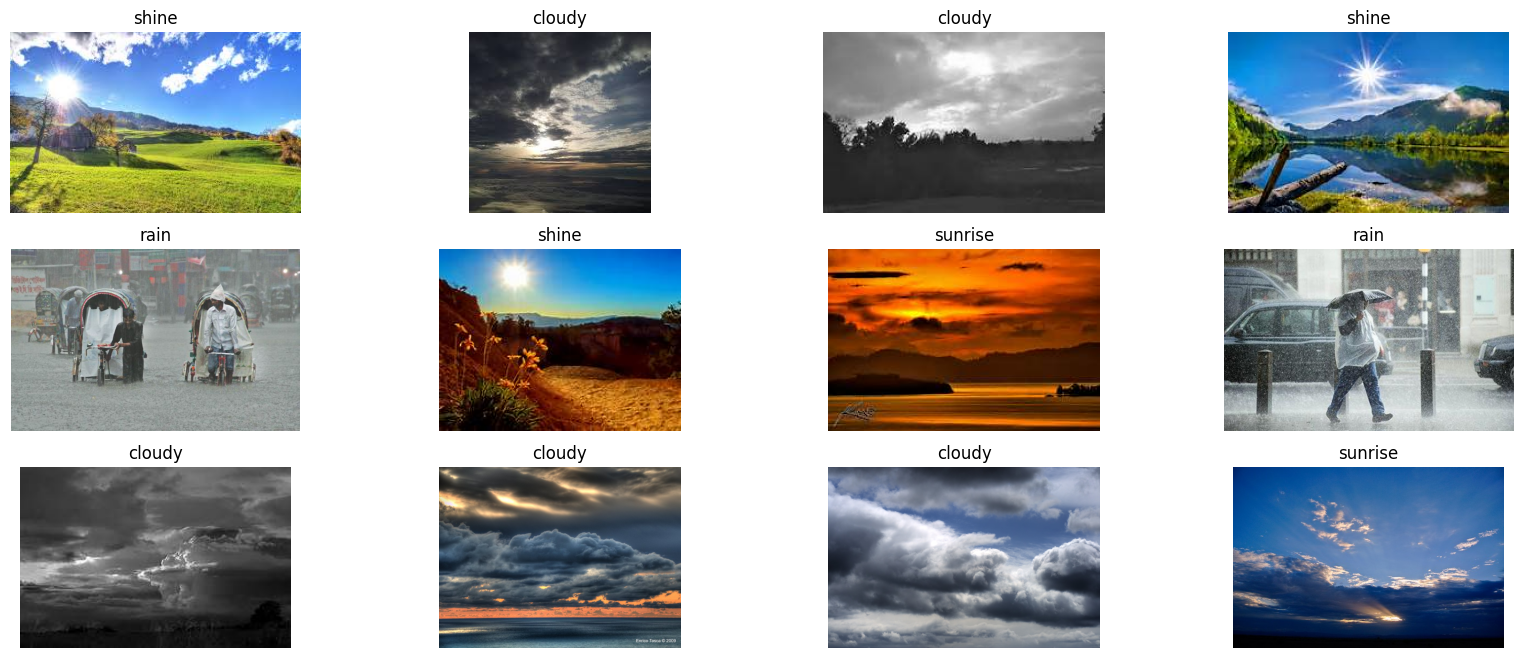

In [ ]:
# View some images
image_samples = np.random.randint(0,high=len(data_x)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_y[img_idx])
    # Read image
    image = cv2.imread(data_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.show()

#### Build Data Pipelines

##### Split Data

In [ ]:
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 899
validate_x count: 225


##### Create TF Dataset

In [ ]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
train_buffer_size = 900
validate_buffer_size = 225

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size=train_buffer_size)
train_data = train_data.batch(batch_size)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.shuffle(buffer_size=validate_buffer_size)
validation_data = validation_data.batch(batch_size)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
validation_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Build Teacher Model

#### Teacher Model

Teacher model is a mobilenet_v2 model which we get from directly from tfhub.





In [ ]:
def build_teacher_model(image_height, image_width, num_channels, num_classes):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model (Use a different model here)
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        layers.InputLayer(input_shape=input_shape),
                                hub.KerasLayer(handle, trainable=False),
        layers.Dense(units=64, activation='relu',
                               kernel_regularizer=regularizers.l1(kernel_weight),
                               bias_regularizer=regularizers.l1(bias_weight)),
        layers.Dense(units=num_classes,
                                  kernel_regularizer=tf.keras.regularizers.l1(kernel_weight),
                                  bias_regularizer=tf.keras.regularizers.l1(bias_weight))
  ],name='teacher_model')

  return model

#### Train Teacher

Nothing magical about this step. We just train the teacher network.

Model: "teacher_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2340228 (8.93 MB)
Trainable params: 82244 (321.27 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


None
Training execution time (mins) 3.8999985257784524


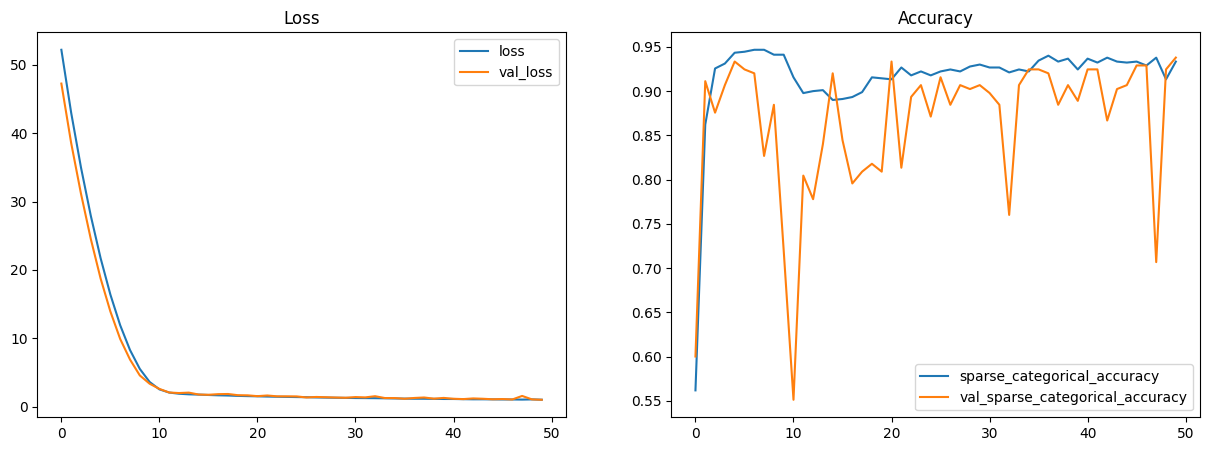

8/8 [==============================] - 1s 37ms/step - loss: 0.9881 - sparse_categorical_accuracy: 0.9378
{'loss': 0.988097071647644, 'sparse_categorical_accuracy': 0.9377777576446533}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NameError: name 'total_params' is not defined

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 50

# Free up memory
K.clear_session()

# Build the teacher model
teacher_model = build_teacher_model(image_height, image_width, num_channels, num_classes)
print(teacher_model.summary())

# Optimizer
optimizer = optimizers.SGD(lr=learning_rate)
# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
teacher_model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[metrics.SparseCategoricalAccuracy()])

# Train model
start_time = time.time()
training_results = teacher_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=0)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(teacher_model,validation_data, training_results,execution_time,
               learning_rate, epochs, optimizer,save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

## Build Student Model

#### Student Model

Student model is just 2 conv layers with max pooling and a dense layer

In [ ]:
def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels
  model_name =  model_name +"_"+ str(int(time.time()))



  model = Sequential(
      [
        keras.Input(shape=input_shape),
        layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(units=num_classes)
      ],
      name=model_name)

  return model

#### Train Student from Scratch (for comparison)

Model: "student_scratch_1709461243"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272

None
Training execution time (mins) 0.7838676691055297


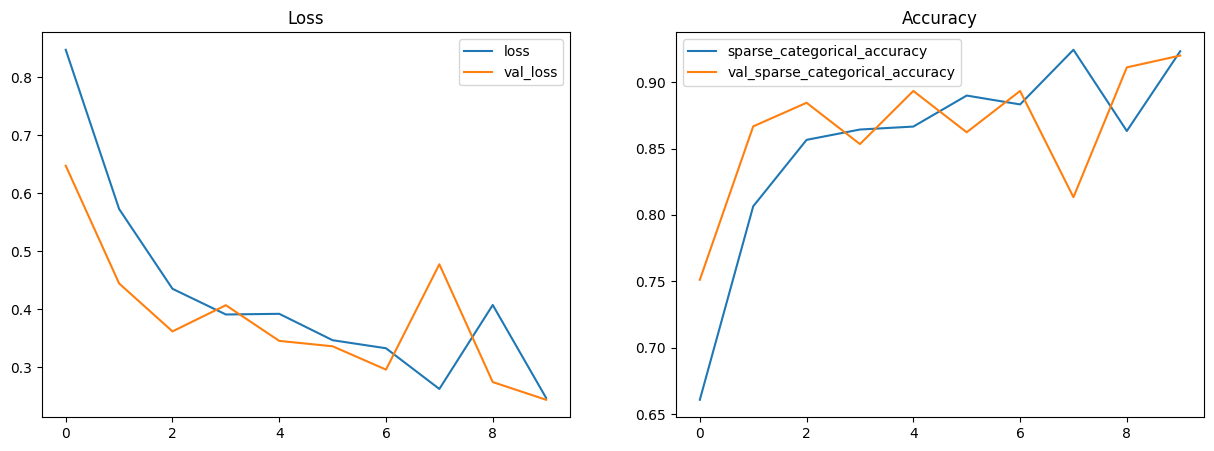

8/8 [==============================] - 1s 12ms/step - loss: 0.2436 - sparse_categorical_accuracy: 0.9200
{'loss': 0.24356205761432648, 'sparse_categorical_accuracy': 0.9200000166893005}


NameError: name 'total_params' is not defined

In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10

# Free up memory
K.clear_session()

# Build the model
student_model_scratch = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_scratch')
print(student_model_scratch.summary())

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate)
# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[metrics.SparseCategoricalAccuracy()])

# Train teacher model
start_time = time.time()
training_results = student_model_scratch.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=0)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(student_model_scratch,validation_data, training_results,execution_time,
               learning_rate, epochs, optimizer,save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

## Build Distiller

In [ ]:
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self,optimizer,metrics,student_loss_fn,distillation_loss_fn,alpha=0.1,temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

## Distill Teacher to Student

In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
alpha=0.9
temperature=15

# Free up memory
K.clear_session()

# Build Student model
student_model = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_distill')
print(student_model.summary())

# Build the distiller model
distiller_model = Distiller(teacher=teacher_model, student=student_model)

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate)
# Loss
student_loss = losses.SparseCategoricalCrossentropy(from_logits=True)
distillation_loss = losses.KLDivergence()

# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[metrics.SparseCategoricalAccuracy()],
    alpha=alpha,
    temperature=temperature
)

# Distill teacher to student
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=0)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluation_results = evaluate_model(distiller_model,validation_data,
               training_results,execution_time,
               learning_rate, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

# Save student model
save_model(student_model,training_results,execution_time,learning_rate, epochs, optimizer, evaluation_results)

## Compare All Models

In [ ]:
models_store_path = "models"

models_metrics_list = glob(models_store_path+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['total_params'] = view_metrics['total_params'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} KB'.format)

# Filter columns
view_metrics = view_metrics[["total_params","execution_time",
                             "loss","accuracy","model_size","learning_rate","epochs","optimizer","name"]]
view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)